# Arbres de décision et forêts aléatoires

Les forêts aléatoires sont un exemple de méthodes *ensemblistes* qui consiste à aggréger plusieurs estimateurs : des arbres de décisions. Le résultat, quelque peu surprenant, est que la somme peut être meilleure que les éléments : c'est-à-dire qu'un vote majoritaire (pour la classification) ou une moyenne (pour la régression) de plusieurs estimateurs peut faire mieux que chaque estimateur pris séparément.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Les arbres de décisions

Les arbres de décisions (*CART pour Classification And Regression Trees*) sont une méthode très intuitive pour classer/labeliser des objets. Il s'agit simplement de se poser une série de question axée sur le problème de classification. Par exemple, pour construire un arbre de décision pour classer un animal croisé en randonnée, on pourrait construire l'arbre suivant :

![](decision-tree.png)

Le fait de faire des séparations binaire chaque fois rend cette méthode extrêment efficace. En effet, dans un arbre bien construit, chaque question divise approximativement par 2 le nombre d'options qui diminue donc très rapidement, même pour une grand nombre de classes.  
La difficulté réside donc bien évidemment dans le choix des questions à poser à chaque étape.  
En *machine learning*, pour l'implémentation des arbres de décision, les questions consistent à découper verticalement ou horizontalement les données, c'est-à-dire que chaque noeud de l'arbre sépare les données en 2 sous-ensemble en utilisant une valeur seuil au sein d'une caractéristique.  
On va voir plus clair par la suite.

### Créer un arbre de décision

On considère les données suivantes qui sont bi-dimensionnelles et qui sont labellisées selon 4 classes différentes. Par exemple, pour rester dans le thème herriko, cela pourrait être 4 races de viandes bovines différentes pour lesquelles on disposerait de la taille et du poids.

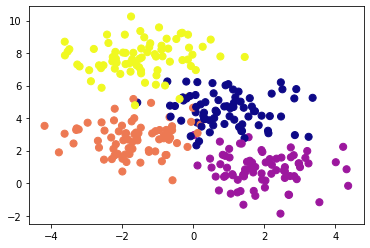

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
#sns.set_style('darkgrid',{'axes.facecolor':'black'})
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='plasma');

Bon pour une taille et un poids de bovin, l'échelle des valeurs est pas vraiment appropriée, mais on peut imaginer que c'est le cas...

Un arbre de décision construit sur ce dataset va découper successivement les données selon l'un ou l'autre des axes (c'est-à-dire selon l'un ou l'autre des *features*) en fonction d'une valeur seuil. À chaque découpage, il attribue comme label aux nouvelles régions celui de la classe majoritaire.
La figure ci-dessous représente les 4 premiers découpages d'un arbre de décision sur ces données.

![](decision-tree-levels.png)

On remarque qu'après le premier découpage, la zone supérieure reste inchangée puisque tous les points sont dans la même classe, il n'est donc pas nécessaire de diviser à nouveau cette région. Ainsi, à chaque étape, on redécoupe selon un des axes uniquement les zones pour lesquelles il y a encore plusieurs couleurs de points (c'est-à-dire des points de différentes classes).

Dans Scikit-Learn, l'estimateur ``DecisionTreeClassifier`` permet de d'ajuster à nos données un arbre de décision de cette manière :

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [4]:
#fonction pour afficher les classifieurs
def viz(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # affichage des données initiales
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, zorder=2)
    ax.axis('tight')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fitting de l'estimateur
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # créer un graphique avec les zones découpées
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

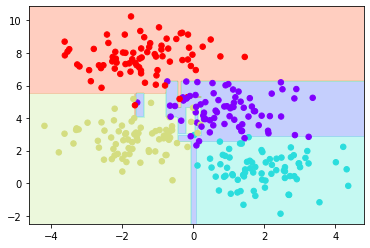

In [5]:
# visualisation de l'arbre de décision
viz(DecisionTreeClassifier(), X, y)

On peut améliorer un peu l'affichage en faisant un plot interactif avec `interact` de `ipywidgets` pour avoir un graphique qui varie en fonction de la profondeur de l'arbre.

In [7]:
# Affichage interactif
from ipywidgets import interact

def interactive_viz(X, y):
    def tree_viz(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        viz(clf, X, y)

    return interact(tree_viz, depth=[1,2,3,4,5])

In [8]:
interactive_viz(X, y);

interactive(children=(Dropdown(description='depth', index=4, options=(1, 2, 3, 4, 5), value=5), Output()), _do…

On remarque que lorsque la profondeur de l'arbre augmente, on obtient des régions découpées bizarrement. Par exemple, pour une profondeur de 5, il y a une toute petite zone verticale violette dans la partie inférieure. Il s'agit clairement d'une zone qui est liée au bruit au sein du dataset plutôt qu'à la distribution des données. ON voit donc qu'un arbre de décision, même avec un profondeur de seulement 5 niveaux, est sujet à *l'over-fitting*. 

### Arbres de décision et *over-fitting*

Ce problème d'*over-fitting* se trouve être une caractéristique générale des arbres de décision : on se retrouve très vite trop profond dans un arbre, et donc, on sur-apprend en allant trop en détail sur nos données plutôt que de s'en tenir aux propriétés globles des distributions de nos données.  
Une autre manière de voir ce problème consiste à regarder les modèles entraînés sur des sous-ensembles du dataset. Par exemple, la figure ci-dessous regroupe les 2 arbres obtenus en entraînant sur uniquement une moitié des données.

![](decision-tree-overfitting.png)

Il y a clairement des zones où les 2 arbres ont les mêmes résultats, les 4 coins par exemple (ce qui est rassurant mais bon...). En revanche, dans certaines autres régions, notamment toutes les zones qui se situent entre 2 clusters, les résultats sont très différents.  
On constate que les zones où les résultats sont incohérents sont celles où la classification est plus incertaine et par conséquent, en utilisant les information des 2 arbres, on pourrait obtenir un meilleur résultat ! C'est ce qui va nous faire passer de l'arbre de décision à la forêt aléatoire.

In [9]:
# affichage interactif d'arbres qui sont entraînés sur des sous-ensembles aléatoires du dataset
def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        viz(clf, X[i[:N]], y[i[:N]])
    
    interact(fit_randomized_tree, random_state=list(range(51)));

In [10]:
randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …

### Petite digression

On peut afficher l'arbre de décision construit avec la fonction export_graph sous forme de fichier dot puis le transformer en PDF par exemple.

In [11]:
# on charge des données réelles, qui ont du sens
from sklearn.datasets import load_iris
iris = load_iris()

# on fit un arbre de décision
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

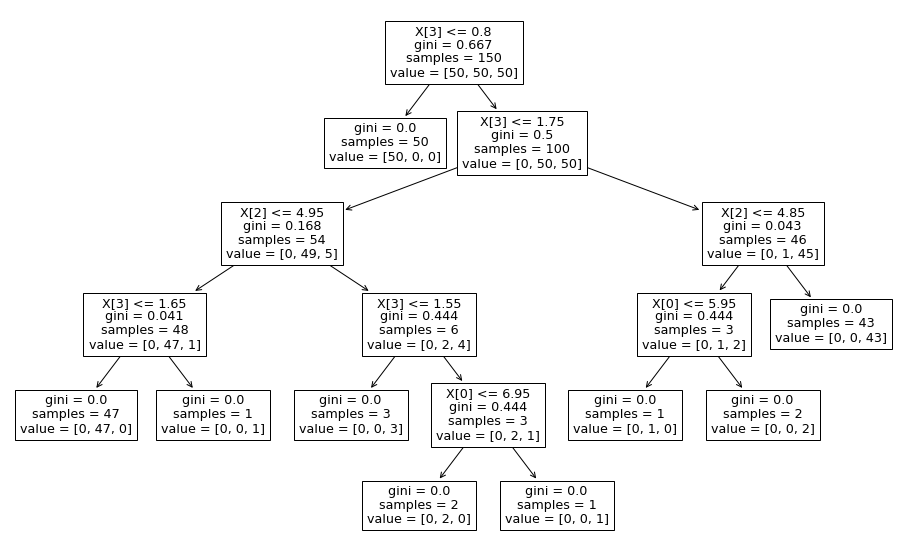

In [12]:
# on peut afficher l'arbre avec plot_tree
plt.figure(figsize=(16,10))
tree.plot_tree(clf.fit(iris.data, iris.target));

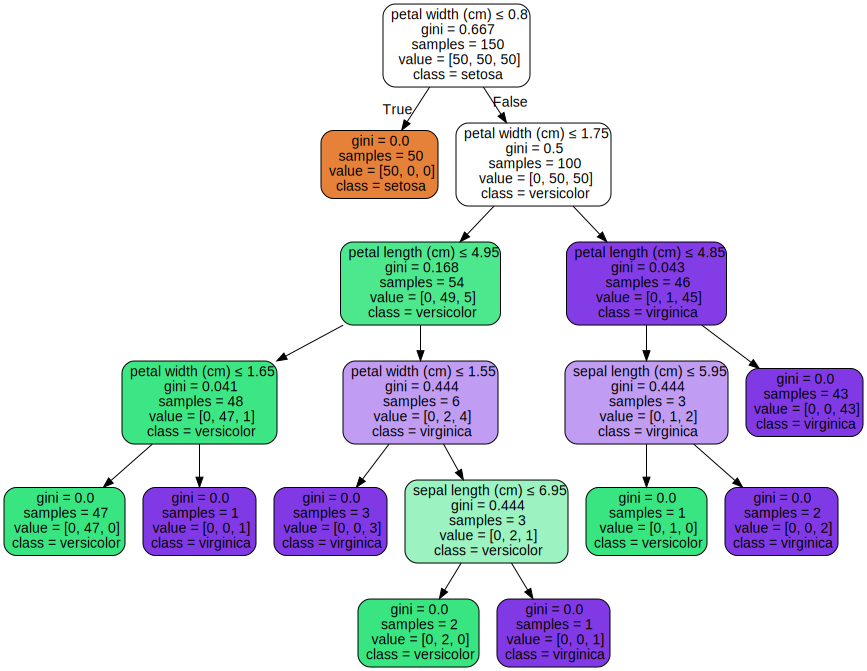

In [13]:
# on peut ensuite exporter le graphique en pdf avec le package graphviz
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, # les paramètres supplémentaires permettent de colorer selon les classes par exemple
            feature_names=iris.feature_names,
            class_names=iris.target_names,
            filled=True, rounded=True,
            special_characters=True) 
graph = graphviz.Source(dot_data) 
#graph.render("iris") pour l'export en pdf
graph

In [26]:
clf.feature_importances_

array([0.02666667, 0.        , 0.05072262, 0.92261071])

In [14]:
# on peut aussi utiliser graph_from_dot_data de pydotplus
from pydotplus import graph_from_dot_data
dot_data = tree.export_graphviz(clf, out_file=None,
            feature_names=iris.feature_names,
            class_names=iris.target_names,
            filled=True, rounded=True,
            special_characters=True)
graph = graph_from_dot_data(dot_data)
graph.write_pdf("iris.pdf")

True

## Méthodes ensemblistes : les forêts aléatoires

Cette idée (à savoir des estimateurs qui sur-apprennent peuvent être combinés pour réduire les effets de ce sur-apprentissage) est à l'origine d'une méthode ensembliste appelée le *bagging*. Cette méthode consiste à utiliser un ensemble d'estimateurs en parallèle, chacun étant sujet au sur-apprentissage, et à moyenner les résultats pour finalement réduire la variance des estimateurs.

On peut appliquer *bagging* aux arbres de décision avec le meta-estimateur `BaggingClassifier` de Scikit-Learn.

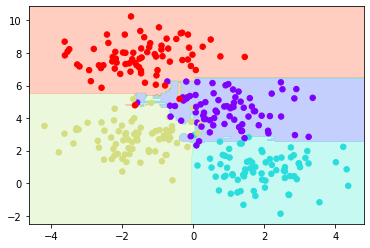

In [15]:
from sklearn.ensemble import BaggingClassifier
bag_tree = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=0.8, random_state=0)
bag_tree.fit(X, y)
viz(bag_tree, X, y)

Dans cet exemple, on a introduit de l'aléatoire en ajustant chaque arbre avec un sous-échantillon aléatoire de 80% du dataset initial.

Les **forêts aléatoires** sont en fait une amélioration du *bagging* appliqué aux arbres de décision dans lequel on se débrouille pour que les arbres de décision soient bien indépendants les uns des autres. 
Pour en savoir plus : [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest)

Dans Scikit-Learn, cette méthode d'ensemble d'arbres de décisions aléatoires est implémentée via l'estimateur `RandomForestClassifier`. Tout ce qu'il y a à fixer c'est le nombre d'estimateurs et l'entraînement de l'ensemble des arbres se fait très rapidement (en parallèle si on le souhaite).

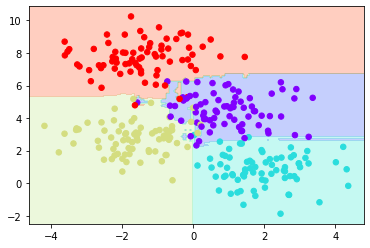

In [16]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
viz(model, X, y);

On voit bien qu'en moyennant sur 100 estimateurs en sur-apprentissage, on obtient un modèle global qui est proche du découpage que l'on aurait fait intuitivement.

## La régression avec les forêts aléatoires

Dans la partie précédente, on a considéré les forêts aléatoires dans le contexte de la classification. On peut également s'en servir pour un problème de régression (c'est-à-dire pour une variable dépendante continue et non catégorique). L'estimateur utilisé dans ce cas est `RandomForestRegressor` dont la synthaxe est quasiment la même que précédemment.

On va utiliser les données suivantes, générées à d'une combinaison d'oscillations rapides et lentes.

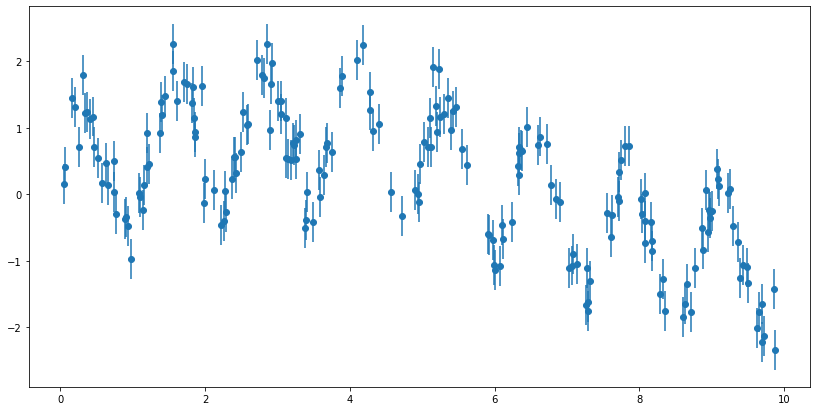

In [17]:
np.random.seed(42)
x = 10 * np.random.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)

plt.figure(figsize=(14,7))
plt.errorbar(x, y, 0.3, fmt='o');

On peut ensuite utiliser une forêt aléatoire pour ajuster une courbe sur ces données.

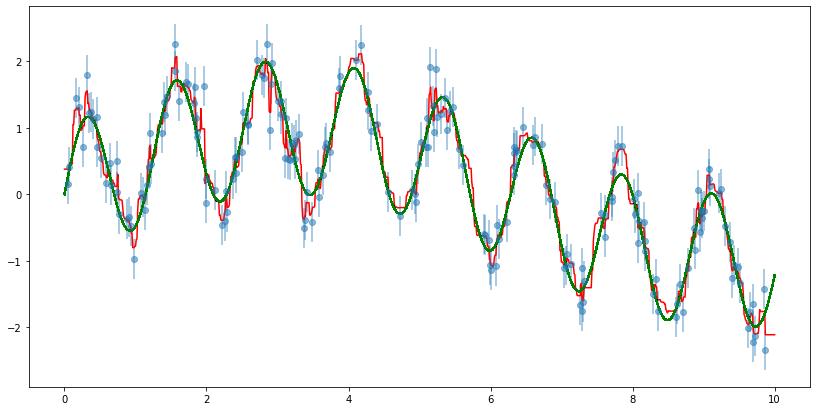

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(200)
rf.fit(x.reshape(-1,1), y)

x_val = np.linspace(0, 10, 1000).reshape(-1,1)
y_pred = rf.predict(x_val)
y_reel = model(x_val, sigma=0)

plt.figure(figsize=(14,7))
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(x_val, y_pred, '-r');
plt.plot(x_val, y_reel, '-g');

Le véritable modèle est tracé en vert et la forêt aléatoire en rouge. Comme on peut le voir, la forết aléatoire, qui est un estimateur non-paramétrique, est suffisamment flexible pour s'ajuster à des données relativement complexes.

## Retour sur la classification de chiffres manuscrits

On a déjàvu le jeu de données load_digits, voyons ce que peut faire une forêt aléatoire pour la classification de ces données.

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

Pour nous rappeler à quoi ressemblent les données, on va afficher les premières images.

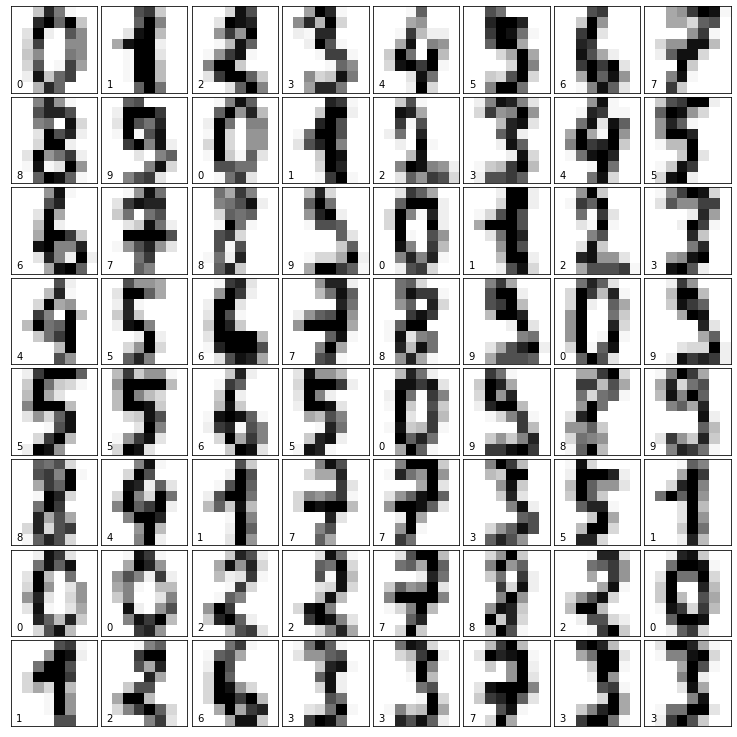

In [20]:
fig = plt.figure(figsize=(10, 10))  
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap='Greys')
    ax.text(0, 7, str(digits.target[i]))

Une petite forêt aléatoire rapide et sympa.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,random_state=0)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

On regarde ce que ça a donné.

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.96      0.96      0.96        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.96      0.97        48

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Et pour y voir plus clair, on peut afficher la matrice de confusion.

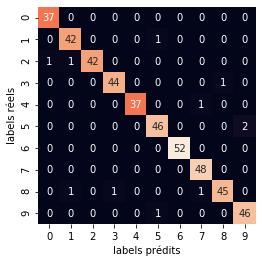

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('labels prédits')
plt.ylabel('labels réels');

Une forêt aléatoire, même sans affiner les différents paramètres, donne de bons résultats pour la classification de chiffres manuscrits.

In [24]:
# on peut aussi obtenir des probabilités estimées avec predict_proba
probas = rf.predict_proba(X_test)
probas[:5,:]

array([[0.002, 0.01 , 0.851, 0.048, 0.   , 0.015, 0.   , 0.016, 0.042,
        0.016],
       [0.006, 0.06 , 0.074, 0.028, 0.059, 0.089, 0.012, 0.039, 0.58 ,
        0.053],
       [0.   , 0.003, 0.98 , 0.006, 0.   , 0.001, 0.002, 0.001, 0.006,
        0.001],
       [0.005, 0.042, 0.036, 0.018, 0.024, 0.057, 0.774, 0.004, 0.035,
        0.005],
       [0.018, 0.002, 0.004, 0.005, 0.015, 0.015, 0.928, 0.001, 0.012,
        0.   ]])

In [25]:
rf.feature_importances_

array([0.00000000e+00, 2.48083809e-03, 2.10775507e-02, 1.03853632e-02,
       9.53635530e-03, 1.85231103e-02, 8.27047348e-03, 6.59773911e-04,
       7.22211121e-05, 9.96603046e-03, 2.76079987e-02, 7.06713515e-03,
       1.60859305e-02, 2.89840607e-02, 5.10530812e-03, 5.27736645e-04,
       3.91693397e-05, 7.58160203e-03, 2.18588517e-02, 2.51915672e-02,
       2.89591178e-02, 4.91291432e-02, 8.40485731e-03, 4.17824138e-04,
       2.02140096e-05, 1.37600460e-02, 4.30023646e-02, 2.52069511e-02,
       3.56838099e-02, 2.38655632e-02, 3.00488365e-02, 8.59957154e-06,
       0.00000000e+00, 3.23276108e-02, 2.69424484e-02, 1.70123948e-02,
       3.93181877e-02, 2.08356021e-02, 2.34454376e-02, 0.00000000e+00,
       2.45884985e-05, 1.14924690e-02, 3.39380565e-02, 4.57823390e-02,
       2.16064192e-02, 2.08426818e-02, 1.67499528e-02, 9.25487555e-05,
       2.84176536e-05, 2.75832295e-03, 1.68948784e-02, 2.04218078e-02,
       1.37918462e-02, 2.31326136e-02, 2.52596086e-02, 1.47329357e-03,
      

## Pour résumer

On a rapidement introduit le concept des *estimateurs ensemblistes* et en particulier la forêt aléatoire qui est un ensemble d'arbres. C'est un estimateur puissant qui présente plusieurs avantages:
- Il est très rapide (aussi bien l'entraînement du modèle que pour les prédictions de nouvelles données) grâce à la simplicité des arbres de décisions eux-mêmes. Par ailleurs on peut effectuer les calculs en parallèles sur les différents arbres car ceux-ci sont tout à fait indépendants
- Il s'agit d'une classification probabiliste ce qui veut dire qu'on peut associer à chaque observation une probabilité estimée d'appartenance aux différentes classes
- C'est un modèle non-paramétrique extrêmement flexible qui a de bonnes performances là où d'autres modèles auraient tendance à sous-apprendre.

Un désavantage notable des forêts aléatoires est que les résultats sont difficilement interprétables.

## Un peu de documentation

Quelques documents sur la théorie et l'implémentation des arbres et forêts aléatoires:
- https://scikit-learn.org/stable/modules/tree.html#tree
- https://scikit-learn.org/stable/modules/ensemble.html#forest
- https://www.lri.fr/~antoine/Courses/ENSTA/Tr.%20Cours%20ID3x9.pdf
- https://math.unice.fr/~malot/presCART.pdf
- https://hal.archives-ouvertes.fr/hal-01387654v2/document